# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

import os
import numpy as np
import torch

import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

# define training and test data directories
data_dir = '/data/landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# convert data to a normalized torch.FloatTensor
# perform resize and center crop similar to AlexNet architecture
train_transform = transforms.Compose([transforms.Resize((256, 256)),
                                     transforms.CenterCrop(227),
                                     transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                     transforms.RandomRotation(10), # rotate by 10 degrees
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

# no augmentation performed on test / validation set
test_transform = transforms.Compose([transforms.Resize((256, 256)),
                                     transforms.CenterCrop(227),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])


# select the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform = train_transform)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))


Num training images:  4996
Num test images:  1250


### DataLoaders and Data Visualization

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))

np.random.seed(0)
np.random.shuffle(indices)

# split on 20% of training data
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# prepare data loaders usining training data
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
# prepare data loaders usining test data
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
- I did some research on the **AlexNet** architecture and found that some of the initial transformations in their architecture is to resize images to a dimension of 256x256 and to perform data augmentation by extracting random crops of size 227×227 from inside the 256×256 image boundary to use as the network’s inputs. Normalization is being performed using  `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)` so that the RBG values will have normalized pixel values from a range from zero to 1.

- Additional augmentation has been applied which will randomly flip the image along the horizontal axis and rotate the image by 10 degrees in order to give them some geometric variation.  The reason I chose to apply image augmentation is so that the model can learn an invariant representation of the image and this is because we don't want the model to change its prediction based on the size, scale, or angle of the object.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# create a list of class names by grabbing the element in index 1
classes = [class_name.split('.')[1] for class_name in train_data.classes]
print('Number of classes:', len(classes))

Number of classes: 50


In [4]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

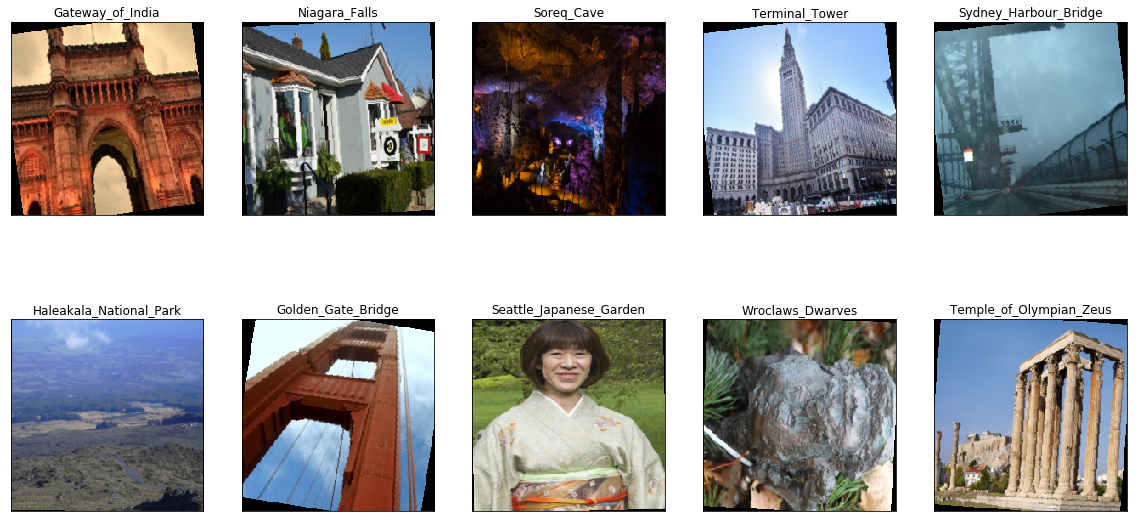

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 10))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Initialize use_cuda variable

In [6]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [7]:
import torch.nn as nn
import torch.optim as optim


## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=0.001)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # convolutional layer (sees 32x32x3 image tensor) and outputs 16 feature maps
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 image tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # torch.Size([17, 64, 28, 28]) or (64 * 32 * 32 -> 1024)
        self.fc1 = nn.Linear(64 * 28 * 28, 1024)
        # linear layer (1024 -> 512)
        self.fc2 = nn.Linear(1024, 256)
        # linear layer (512 -> 50)
        self.fc3 = nn.Linear(256, 50)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # check the dimension of X
#         print(x.shape)
        
        # flatten image input
        x = x.view(-1, 64 * 28 * 28)
        
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3rd hidden layer with relu activation function
        x = self.fc3(x)
           
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
# print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=50, bias=True)
  (dropout): Dropout(p=0.25)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
The CNN architecture contains 3 convolutional layers where each layer uses a kernel size of 3x3, a stride of 1, and a padding of 1.
- **Stride** refers to the amount by which the filter slides over the image. A stride of 1 makes the convolutional layer roughly the same width and height as the input image.  If we make the stride equal to 2 than the convolutional layer is roughly half the width and height of the image.
- **Padding** is where we pad the image with zeros to give the convolutional layer more space to move as it slides across the image.

The 1st convolutional layer starts with an image depth of 3 and then moves to 16.  The 2nd convolutional layer starts with an image depth of 16 and then moves to 32, and in the last layer the image depth at 32 and moves to 64.  Each convolutional layer doubles the depth of the output until we get to the 3rd layer which produces a depth of 64.

The maxpooling layer downsamples an XY size by two and the dropout layer prevents overfitting.  The `forward` function has a pooling layer is applied to each convolutional layer.

The 1st fully connected layer takes as input the downsized feature maps and produces 1024 outputs which get fed as an input to the 2nd fully connected layer.  The 2nd fully connected layer takes the 1024 inputs and produces 512 outputs. Finally, the 3rd fully connected layer takes the 512 inputs and outputs 50 class scores.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [9]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
        
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1/(batch_idx+1))*(loss.data.item() - valid_loss))
        

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch,train_loss,valid_loss))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,valid_loss))
        
        torch.save(model.state_dict(), save_path)
        valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [10]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        num_inputs = m.in_features
        # create a dsitribution model that uses the general rule for weight initialization
        y = 1.0/np.sqrt(num_inputs)
        m.weight.data.uniform_(-y, y) # uniform rule
        m.bias.data.fill_(0)
    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.912012 	Validation Loss: 3.911871
Epoch: 2 	Training Loss: 3.911811 	Validation Loss: 3.911804
Epoch: 3 	Training Loss: 3.911204 	Validation Loss: 3.911444
Epoch: 4 	Training Loss: 3.911231 	Validation Loss: 3.911360
Epoch: 5 	Training Loss: 3.910731 	Validation Loss: 3.911174
Epoch: 6 	Training Loss: 3.910352 	Validation Loss: 3.910882
Epoch: 7 	Training Loss: 3.909891 	Validation Loss: 3.910637
Epoch: 8 	Training Loss: 3.909589 	Validation Loss: 3.910282
Epoch: 9 	Training Loss: 3.909490 	Validation Loss: 3.910089
Epoch: 10 	Training Loss: 3.909123 	Validation Loss: 3.909704
Epoch: 11 	Training Loss: 3.908419 	Validation Loss: 3.909456
Epoch: 12 	Training Loss: 3.908153 	Validation Loss: 3.909254
Epoch: 13 	Training Loss: 3.907562 	Validation Loss: 3.908742
Epoch: 14 	Training Loss: 3.907204 	Validation Loss: 3.908502
Epoch: 15 	Training Loss: 3.906096 	Validation Loss: 3.907880
Epoch: 16 	Training Loss: 3.905505 	Validation Loss: 3.907091
Epoch: 17 	Traini

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [11]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.913106 	Validation Loss: 3.912020
Epoch: 2 	Training Loss: 3.912438 	Validation Loss: 3.911791
Epoch: 3 	Training Loss: 3.912083 	Validation Loss: 3.911526
Epoch: 4 	Training Loss: 3.911900 	Validation Loss: 3.911411
Epoch: 5 	Training Loss: 3.911646 	Validation Loss: 3.911109
Epoch: 6 	Training Loss: 3.911193 	Validation Loss: 3.910900
Epoch: 7 	Training Loss: 3.910835 	Validation Loss: 3.910605
Epoch: 8 	Training Loss: 3.910614 	Validation Loss: 3.910348
Epoch: 10 	Training Loss: 3.909869 	Validation Loss: 3.909849
Epoch: 11 	Training Loss: 3.909072 	Validation Loss: 3.909361
Epoch: 12 	Training Loss: 3.908731 	Validation Loss: 3.909035
Epoch: 13 	Training Loss: 3.907942 	Validation Loss: 3.908576
Epoch: 14 	Training Loss: 3.907196 	Validation Loss: 3.908043
Epoch: 15 	Training Loss: 3.906731 	Validation Loss: 3.907400
Epoch: 16 	Training Loss: 3.905740 	Validation Loss: 3.906818
Epoch: 17 	Training Loss: 3.904453 	Validation Loss: 3.905936
Epoch: 18 	Train

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.900065


Test Accuracy:  4% (62/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# use the same data loader that was previously created in part 1
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [ ]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.SGD(model.parameters(), lr=0.001)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
## TODO: Specify model architecture
import torch.nn as nn
from torchvision import models

# load pretrained VGG-16 model which is a model that is 16 layers deep
model_transfer = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

# add last linear layer (n_inputs -> 50 classes)
# new layers automatically have requires_grad = True
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))

model_transfer.classifier[6] = last_layer
    
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'



#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [ ]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

